In [1]:
!pip install colorthief

# IMPORTANT THINGS:

# MEDIAN FILTER (IMPLEMENT OURSELVES)

# DOMINANT COLOR
# https://www.npmjs.com/package/dominant-color

# CONNECTED COMPONENT LABELLING
# (ourselves?)

# BALL MORPHOLOGY
# https://www.npmjs.com/package/ball-morphology

In [2]:
import struct
from PIL import Image
import colorthief

import scipy
import scipy.misc
import scipy.cluster
import scipy.signal

import scipy.ndimage

import numpy as np
import binascii

import matplotlib.pyplot as plt

In [10]:
def toImage(im, a, ch=4):
    to_shape = (im.height, im.width) if ch==1 else (im.height, im.width, ch)
    return Image.fromarray(a.astype('uint8').reshape(to_shape))

In [4]:
print('reading image')
im = Image.open('./data/img_ex_1.png')
# im = im.resize((150, 150))      # optional, to reduce time
ar = scipy.misc.fromimage(im)
shape = ar.shape
ar = ar.reshape(scipy.product(shape[:2]), shape[2])

reading image


In [6]:
class MyColorThief(colorthief.ColorThief):
    """Overrides ColorThief to use direct file data entry"""
    def __init__(self, im_data):
        self.image = im_data

In [7]:
ct = MyColorThief(im)

In [11]:
col = np.array(ct.get_color(quality=5) + (255, ))
print(col)

[ 89 130 117 255]


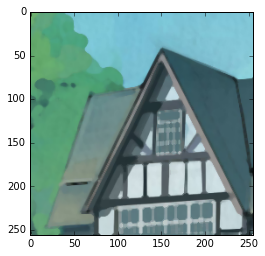

In [12]:
# plt.hist(ar - col)
ar3 = scipy.signal.medfilt(im, kernel_size=(5, 5, 1))
im_med = toImage(im, ar3)
mct = MyColorThief(im_med)
plt.imshow(im_med)
plt.show()

In [14]:
pal = mct.get_palette(color_count=5, quality=5)

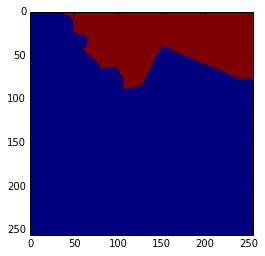

In [15]:
def color_score(rgb, im, ar):
    col = np.array(rgb + (255, ))
#     print(col)
    col_mse = np.square((ar-col) / 255.0).sum(axis=1)
    im2 = toImage(im, (col_mse < 0.01) * 255.0, ch=1)
    
    # smooth the image (to remove small objects)
    imgf = scipy.ndimage.gaussian_filter(im2, sigma=1.0)
    threshold = 50

    # find connected components
    labeled, nr_objects = scipy.ndimage.label(imgf > threshold) 
#     print("Number of objects is %d " % nr_objects)
    binmask = (labeled == 1).astype('int8')
    score = binmask.sum()
    
#     print("Score:", score)
    return col, binmask, score

col, mask, _ = max([color_score(rgb, im, ar) for rgb in pal], key=lambda tri: tri[2])
plt.imshow(mask)
plt.show()
    
#     plt.imshow()
#     plt.show()

#     bins, ranges, _ = plt.hist(col_mse, bins=100)
#     plt.plot((0.02, 0.02), (0, max(bins)))
#     plt.show()

Best width is 9


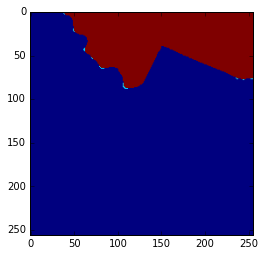

9


In [26]:
tmp = np.zeros_like(mask)
# plt.imshow(mask)
# plt.show()

MAX_W = 30
W_SENS = 20.0

def make_ball(w):
    xsq = (np.r_[:float(w)] - (w/2.0) + 0.5) ** 2
    ysq = (np.c_[:float(w)] - (w/2.0) + 0.5) ** 2
    ball = xsq + ysq
    ball = ball < (w / 2.0) ** 2
    return ball

def w_error(mask, w, tmp):
    padded_dims = [dim + 2 * (w - 1) for dim in mask.shape]
    framed = np.ones(padded_dims)
    framed[w-1:-w+1, w-1:-w+1] = mask
    out = np.zeros_like(framed)
    
    ball = make_ball(w)
    
    scipy.ndimage.morphology.binary_opening(framed, structure=ball, output=out)
    error = (out[w-1:-w+1, w-1:-w+1] - mask).sum()
    return error, out[w-1:-w+1, w-1:-w+1]

prev = 0
eavg = 0
wqs = [0]
wds = [1]

for w in range(2, MAX_W):
    error, tmp = w_error(mask, w, tmp)
    diff = error - prev
    prev = error
    accel = diff - eavg
    eavg = 0.9 * eavg + 0.1 * diff
    if accel < -W_SENS:
        print('Best width is', w)
        plt.imshow(2 * tmp + mask)
        plt.show()
        break

# framed = np.zeros()
print(w)

In [125]:
from skimage.feature import corner_harris, corner_subpix, corner_peaks

coords = corner_peaks(corner_harris(eroded), min_distance=4)
coords_subpix = corner_subpix(eroded, coords, window_size=13)

ball = make_ball(w)
eroded = scipy.ndimage.morphology.binary_erosion(mask, structure=make_ball(w))
# plt.imshow(eroded)
# plt.scatter(coords[:, 1], coords[:, 0])
# plt.show()

In [128]:
def pltshow(im):
    plt.imshow(im.astype('uint8'), interpolation="nearest")
    plt.show()
    
def make_window_index(coord, w):
    return [slice(coord[i] - w, coord[i] + w + 1) for i in [0, 1]]

def where_nonzero(a):
    idx = []
    axes = set(np.r_[:a.ndim])
    for ax in range(a.ndim):
        other_axes = axes.difference({ax})
        dim = a.shape[ax]
        int_range = np.r_[:dim]
        valid_range = int_range[a.sum(axis=tuple(other_axes)) > 0]
        idx += [slice(min(valid_range), max(valid_range))]
    return idx

def pwz(a):
    _idx = where_nonzero(a)
    print(_idx)
    pltshow(a[_idx])
    
# plt.scatter(0 + _w, 0 + _w)
# pwz(outer)
# pwz(eroded)
# pltshow(diff[:100, 40:])
# pltshow(edges[_idx])    

# Initialize
stx = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])
outer = scipy.ndimage.morphology.binary_dilation(eroded, structure=stx)
edges = outer ^ eroded

unvisited = coords[1:]
unvisited = list(coords)
path = [coords[0]]
last_loc = coords[0]
loc = coords[0]



# Iterative: Follow edges
offsets = np.array([
    [0, 1], # N
    [1, 2], # E
    [2, 1], # S
    [1, 0], # W
    [0, 0], # NW
    [2, 0], # NE
    [2, 2], # SE
    [0, 2]  # SW
])
# An offset's offset
center = np.array([1, 1])
while unvisited:
    _idx = make_window_index(loc, 1)
    window = edges[_idx]
    
    # Find the next pixel to go to
    for offset in offsets:
        place = window[tuple(offset)]
        if place:
            try_next = loc + offset - center
            if not (try_next == last_loc).all():
                last_loc = loc
                loc = try_next
                break
    
    # Calculate distances to corners
    for coord in unvisited:
        if max(coord - loc) <= 1:
            path.append(coord)
            unvisited.remove(coord)
            print('Visited', coord)
            print(len(unvisited), 'left')

# THEN!!! (VERY IMPORTANT)
# DILATE THE EDGE IMAGE WITH W
# REMOVE THAT FROM THE ERODED IMAGE
# THIS REPRESENTS THE DRAWING OF THE POLYGON EDGE

Visited [ 4 51]
15 left
Visited [  4 251]
14 left
Visited [20 54]
13 left
Visited [28 68]
12 left
Visited [ 36 148]
11 left
Visited [ 38 160]
10 left
Visited [44 67]
9 left
Visited [ 46 177]
8 left
Visited [ 48 182]
7 left
Visited [60 83]
6 left
Visited [ 64 104]
5 left
Visited [ 72 238]
4 left
Visited [ 72 251]
3 left
Visited [ 73 243]
2 left
Visited [ 79 125]
1 left
Visited [ 83 111]
0 left


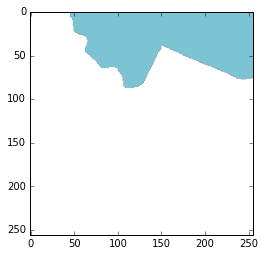

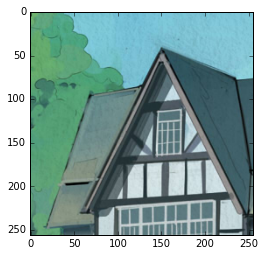

In [32]:
dilated = scipy.ndimage.morphology.binary_dilation(eroded, structure=ball)
plt.imshow((dilated[:, :, None] * col[None, None, :]).astype('uint8'))
plt.show()
plt.imshow(im)
plt.show()

array([[  4,  52],
       [  4, 251],
       [ 19,  54],
       [ 26,  68],
       [ 36, 146],
       [ 38, 162],
       [ 43,  69],
       [ 46, 179],
       [ 48, 184],
       [ 60,  84],
       [ 62, 103],
       [ 72, 239],
       [ 72, 251],
       [ 83, 111]], dtype=int64)

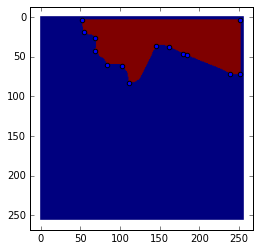

[[-0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0.]
 [-4. -4. -4. -3. -1. -0. -0.]
 [-4. -4. -4. -3. -1. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0.]]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1. -1.  0.  0.]
 [ 0.  0.  0. -3. -3.  0.  0.]
 [ 0.  0.  0. -4. -4.  0.  0.]
 [ 0.  0.  0. -4. -4.  0.  0.]
 [ 0.  0.  0. -4. -4.  0.  0.]]


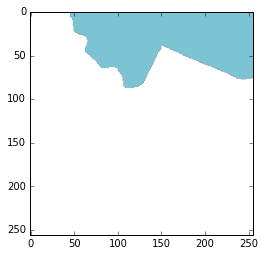

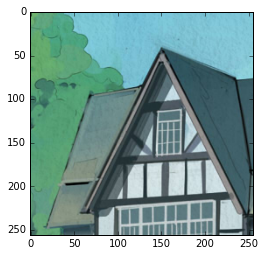